##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Signal Analysis

This tutorial shows how to analysis of signals using a `keras.Sequential` model and load data using `keras.utils.signals_dataset_from_directory`. It demonstrates the following concepts:


* Efficiently loading a dataset off disk.
* Identifying overfitting and applying techniques to mitigate it, including data augmentation and dropout.

This tutorial follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

## Download and explore the dataset

This tutorial uses a dataset of about signals datas of strain gauge sensors.

The dataset is adapted from https://zenodo.org/records/3229743




---


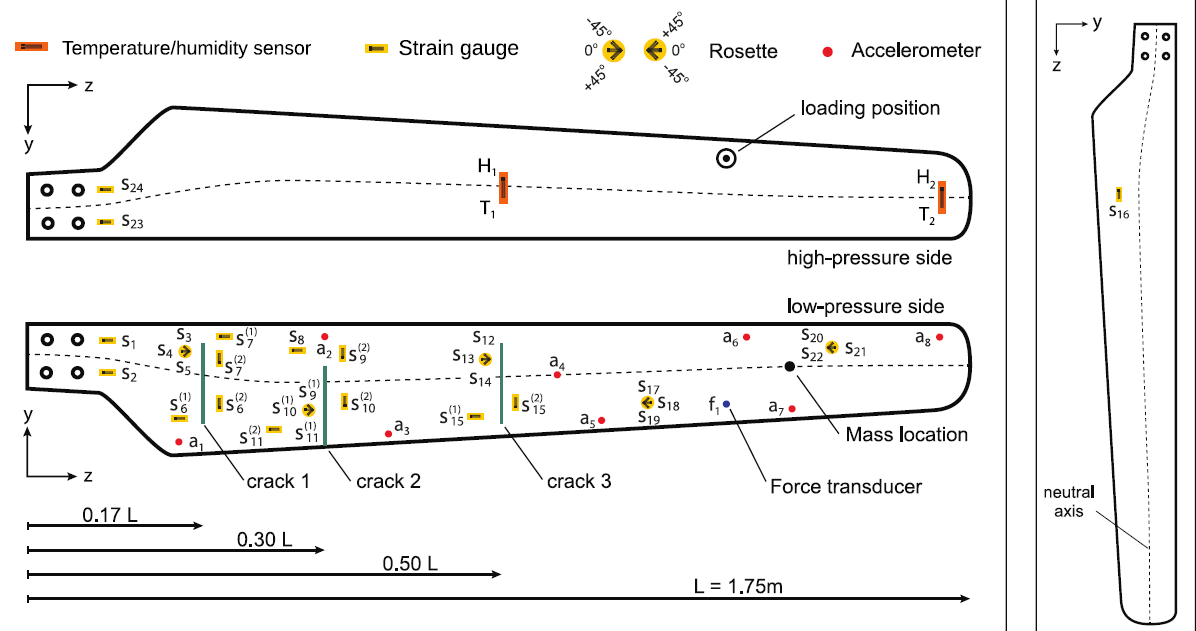

------

It contains five sub-directories, one per class:

```
signal_data/
  15cm/
  30cm/
  45cm/
  repaired/
  undamaged/
```

In [2]:
!git clone http://github.com/AllanKamimura/utils
from utils.myutils import *

link = "https://drive.google.com/file/d/1j50kFoDF1Cebqggfb7EUiQVTVzpZkp6P/edit"

download_drive(link, unzip = True)
!mv -i ./content/drive/MyDrive/casos ./

Cloning into 'utils'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 9 (delta 2), reused 9 (delta 2), pack-reused 0
Receiving objects: 100% (9/9), done.
Resolving deltas: 100% (2/2), done.


## Create csv from directory

In [4]:
!git clone http://github.com/Formiga57/HackatonSEComp2023.git --recurse-submodules
!pip install keras

Cloning into 'HackatonSEComp2023'...
remote: Enumerating objects: 841, done.
remote: Counting objects: 100% (841/841), done.
remote: Compressing objects: 100% (699/699), done.
remote: Total 841 (delta 144), reused 829 (delta 132), pack-reused 0
Receiving objects: 100% (841/841), 31.66 MiB | 19.96 MiB/s, done.
Resolving deltas: 100% (144/144), done.
Updating files: 100% (751/751), done.


### Create a dataset

Define some parameters for the loader:

In [7]:
%cd /content/HackatonSEComp2023/keras
import keras as keras

csv_dataset = keras.utils.csv_dataset_from_directory(
    "/content/casos",
    stride = 1,
    batch_size=2,

)

class_names = csv_dataset.class_names
print(class_names)

Found 50 files belonging to 5 classes.
['caso 15', 'caso 30', 'caso 45', 'caso repaired', 'caso undamaged']


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

## Visualize the data

If you like, you can also manually iterate over the dataset and retrieve batches of signals:

In [8]:
for signal_batch, labels_batch in csv_dataset:
  print(signal_batch.shape)
  print(labels_batch.shape)
  break

(2, 49152, 16)
(2,)


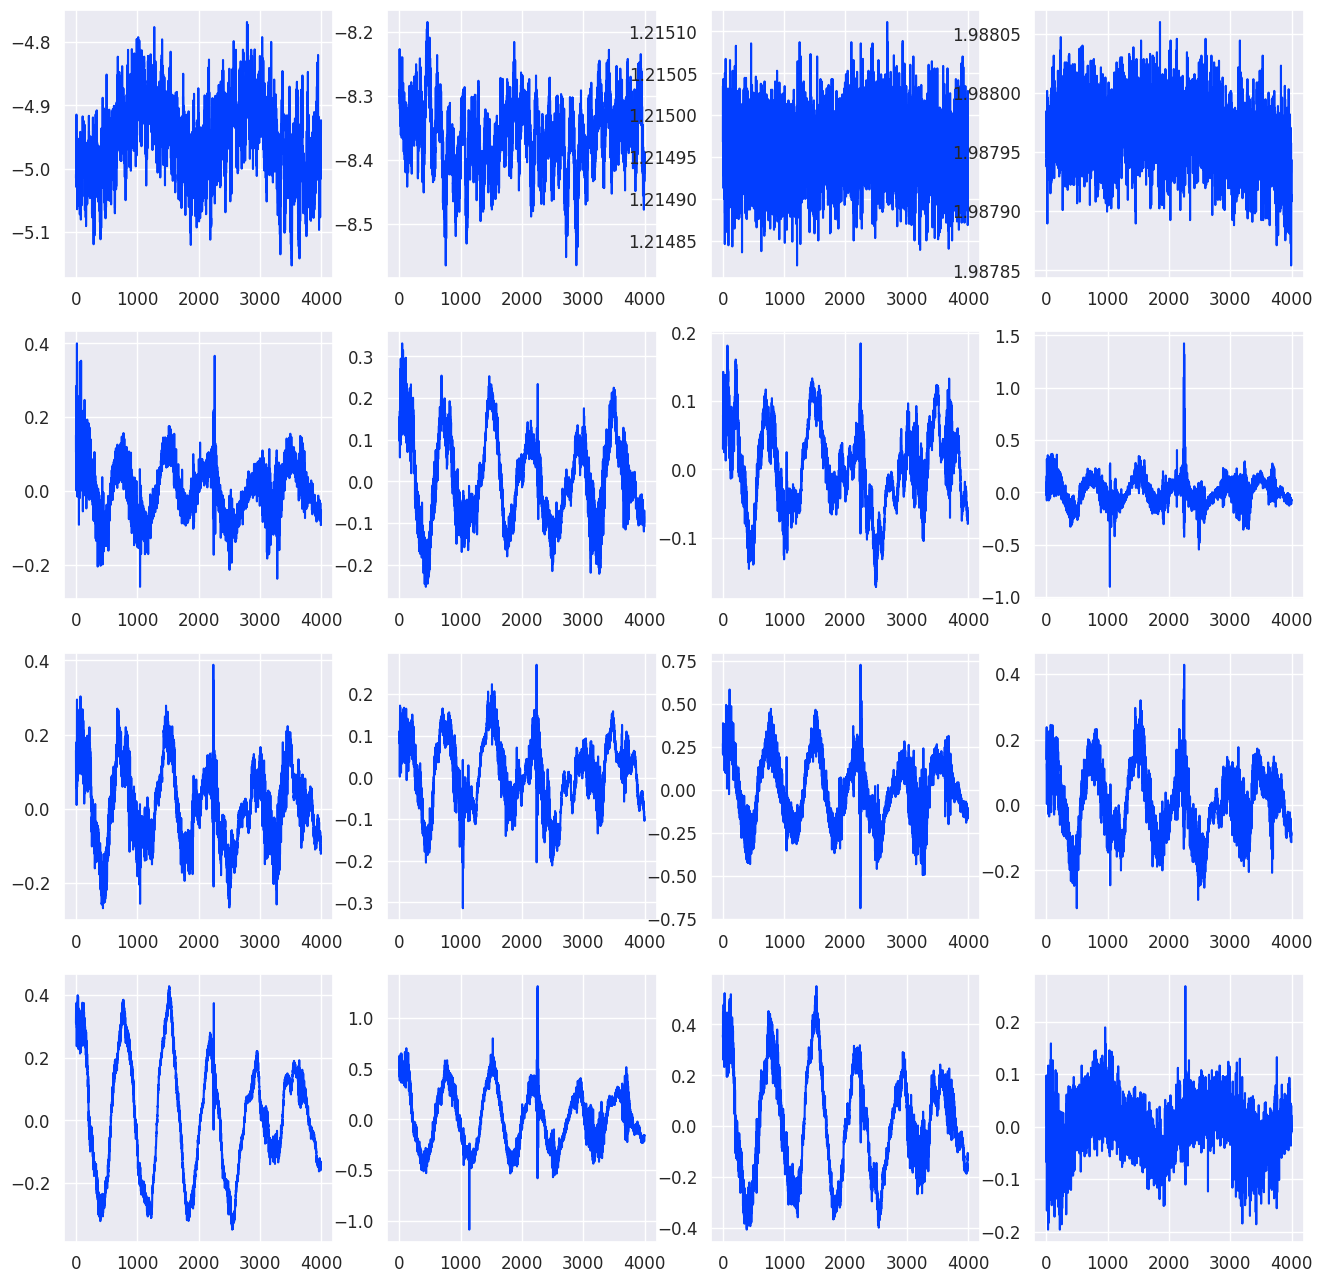

In [9]:
signal = signal_batch[0]

import matplotlib.pyplot as plt
fig, ax = plt.subplots(4,4, figsize = (16,16))

start = 18000
window = 4000

for i in range(16):
    row = i // 4
    col = i % 4
    ax[row, col].plot(signal[start:start+window,i])

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## A basic Keras model

### Create the model

The Keras [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`keras.layers.Conv1D`) with a max pooling layer (`keras.layers.MaxPooling1D`) in each of them. There's a fully-connected layer (`keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`).

In [11]:
num_classes = len(class_names)
model = keras.models.Sequential([
  keras.layers.Conv1D(4, 3, padding='same', activation='relu', input_shape = (signal_batch.shape[-2], signal_batch.shape[-1])),
  keras.layers.MaxPooling1D(),
  keras.layers.GlobalAveragePooling1D(),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(num_classes)
])

/content/HackatonSEComp2023/keras/keras/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


### Compile the model

For this tutorial, choose the `keras.optimizers.Adam` optimizer and `keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [12]:
model.compile(optimizer='adam',
              loss =keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

View all the layers of the network using the Keras `Model.summary` method:

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                    │ (None, 49152, 4)              │         196 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ max_pooling1d (MaxPooling1D)       │ (None, 24576, 4)              │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ global_average_pooling1d           │ (None, 4)                     │           0 │
│ (GlobalAveragePooling1D)           │                               │             │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense (Dense)                      │ (None, 128)                   │         640 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_1 (Dense)                    │ (None, 5)                     │         645 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 1,481 (5.79 KB)

 Trainable params: 1,481 (5.79 KB)

 Non-trainable params: 0 (0.00 B)

### Train the model

Train the model for 10 epochs with the Keras `Model.fit` method:

In [14]:
epochs=10
history = model.fit(
  csv_dataset,
  epochs=epochs
)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 183ms/step - accuracy: 0.2655 - loss: 1.5665
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 305ms/step - accuracy: 0.4949 - loss: 1.3276
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 189ms/step - accuracy: 0.4179 - loss: 1.2070
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 186ms/step - accuracy: 0.5626 - loss: 0.9110
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 317ms/step - accuracy: 0.5904 - loss: 0.9352
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 193ms/step - accuracy: 0.4041 - loss: 1.0490
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 291ms/step - accuracy: 0.4274 - loss: 0.9908
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 203ms/step - accuracy: 0.4722 - loss: 0.9293
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 179ms/step - accuracy: 0.3491 - loss: 1.0329
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 254ms/step - accuracy: 0.4675 - loss: 0.8534


## Visualize training results

Create plots of the loss and accuracy on the training and validation sets:

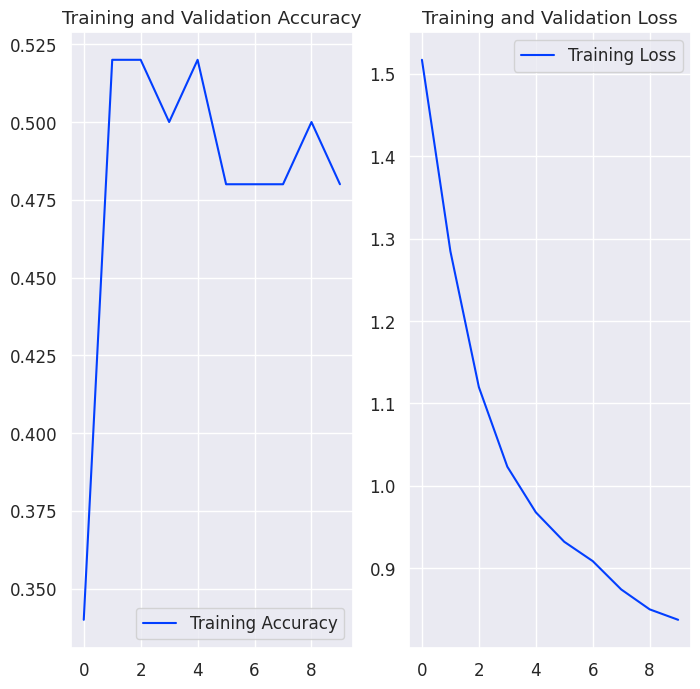

In [15]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']

loss = history.history['loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()